# Plot ACCESS-OM3 SST bias

https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/Model_Agnostic_Analysis.ipynb

In [1]:
%matplotlib inline
import pandas as pd
import intake
import dask
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cftime
import xgcm
import os

import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client

In [2]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [3]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

In [4]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46547,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41765,Total threads: 1
Dashboard: /proxy/38807/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33859,


In [5]:
thisdir = '/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/'

In [6]:
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.iss138/'
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.testAug2024/'
# datastore = intake.open_esm_datastore(PATH+'intake_datastore.json', columns_with_iterables=['variable'])

In [7]:
#PATH='/g/data/tm70/ml0072/COMMON/git_repos/test-Reichl-2025-04-continue/archive/'
#datastore = intake.open_esm_datastore(PATH+'intake_esm_ds.json', columns_with_iterables=['variable'])

OLD

https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/523926733

Everything is here
/g/data/tm70/ml0072/COMMON/git_repos/control_runs/ctrl_25km_1st_version

where

dev-MC_025deg_jra_ryf_alpha_rel covers year 00-19

test-Reichl-2025-04-continue covers 20-48

ctrl_run_25km_0.5 currently covers 49-62. Ongoing data will be temporarily transferred here as well.

dev-MC_025deg_jra_ryf_alpha_rel and test-Reichl-2025-04-continue share the same topo, but different MOM_parameters and different timesteps
the topos are different from test-Reichl-2025-04-continue and ctrl_run_25km_0.5 but they share the same MOM_parameters


OLD

https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/524167154

Minghang Li: Hi Andrew, I've finally managed to move the data to ik11 and just created an esm datastore for this. /g/data/ik11/outputs/access-om3-025/MC_25km_jra_ryf_0.5_prerelease I haven’t tested it yet, so please let me know if you notice anything unusual.

Minghang Li: The most up-to-date year currently available is 1988. I’ll continue transferring data and updating the esm-datastore as new data become available.

Minghang Li: It seems the newly generated ESM datastore might not be correctly configured. I’m reaching out to Charles to see if he can help diagnose the issue.

Minghang Li: Hi Andrew, **We’re using different horizontal grids for the runs - years 0–48 use one version, while years 49 onward use a double precision version.** As a result, when generating the ESM datastore, I’m running into an error due to the differing grid definitions ValueError: Resulting object does not have monotonic global indexes along dimension yh. I can apply some postprocessing to standardise the grid across variables

https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/529767260
```
/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2
/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2_only_neutral_diffusion
/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235
```
These are the three runs related to https://github.com/ACCESS-NRI/access-om3-configs/issues/647#issuecomment-3086863360
`choice2` does not use density coords but is otherwise and identical config to the beta release.

------------------------------

```
/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR
```
is the "formal" beta release run with all settings exactly as on github. It has currently finished 7 years. I plan to continue running it throughout the week and aim to reach 20 years by the end of the week.


In [8]:
catalogs = [
                '/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235/archive/experiment_datastore.json',
                # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2_only_neutral_diffusion/archive/experiment_datastore.json',
                # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2/archive/experiment_datastore.json',
                '/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR/archive/experiment_datastore.json',
            ]
catalogs

['/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235/archive/experiment_datastore.json',
 '/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR/archive/experiment_datastore.json']

In [9]:
datastores = { os.path.normpath(c).split(os.sep)[-3]: intake.open_esm_datastore(c, columns_with_iterables=['variable']) for c in catalogs }
datastores

{'om3_MC_25km_jra_ryf_631+634+235': <experiment_datastore catalog with 37 dataset(s) from 1148 asset(s)>,
 'test_current_config_0.0_w_rho_coord_with_GM_RR': <experiment_datastore catalog with 41 dataset(s) from 4691 asset(s)>}

In [10]:
# get coords from short run without processor masking
# https://github.com/aekiss/MOM6-CICE6/commit/59ed8ffc6ae1d4a79821a951924e7c853d9b788a
# https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#A-note-on-geographical-coordinates
static = xr.open_dataset('/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc')

In [11]:
static

<xarray.Dataset> Size: 368MB
Dimensions:       (xh: 1440, yh: 1142, time: 1, xq: 1440, yq: 1142)
Coordinates:
  * xh            (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yh            (yh) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.95
  * time          (time) object 8B 1900-01-01 00:00:00
  * xq            (xq) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yq            (yq) float64 9kB -80.9 -80.84 -80.77 ... 89.79 89.9 90.0
Data variables: (12/28)
    areacello     (yh, xh) float64 13MB ...
    areacello_cu  (yh, xq) float64 13MB ...
    areacello_cv  (yq, xh) float64 13MB ...
    areacello_bu  (yq, xq) float64 13MB ...
    dxt           (yh, xh) float64 13MB ...
    dyt           (yh, xh) float64 13MB ...
    ...            ...
    dxCu          (yh, xq) float64 13MB ...
    dyCu          (yh, xq) float64 13MB ...
    dxCv          (yq, xh) float64 13MB ...
    dyCv          (yq, xh) float64 13MB ...
    dyCuo         (yh, xq) float64 13MB ...
    dxCvo         (yq, xh) float64 13MB ...
Attributes:
    NumFilesInSet:  1
    title:          ACCESS-OM3
    grid_type:      regular
    grid_tile:      N/A
    history:        created with https://github.com/aekiss/MOM6-CICE6/commit/...

see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition

ACCESS-OM3 uses a non-symmetric memory layout, i.e. all fields have the same i and j sizes. See
https://mom6.readthedocs.io/en/main/api/generated/pages/Horizontal_Indexing.html?highlight=symmetric#declaration-of-variables

`MOM_parameter_doc.layout`:
```
!SYMMETRIC_MEMORY_ = False      !   [Boolean]
                                ! If defined, the velocity point data domain includes every face of the
                                ! thickness points. In other words, some arrays are larger than others,
                                ! depending on where they are on the staggered grid.  Also, the starting index
                                ! of the velocity-point arrays is usually 0, not 1. This can only be set at
                                ! compile time.```


In [12]:
# for non-symmetric 
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

In [13]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [14]:
obsds = xr.open_dataset('/g/data/vk83/prerelease/configurations/inputs/access-om3/mom/initial_conditions/global.25km/2025.06.17/ocean_temp_salt.res.nc')

In [15]:
obsds

<xarray.Dataset> Size: 2GB
Dimensions:             (lon: 1440, lat: 1142, depth: 76, time: 1, nbounds: 2)
Coordinates:
  * lon                 (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat                 (lat) float64 9kB -80.94 -80.87 -80.81 ... 89.84 89.94
  * depth               (depth) float64 608B 0.0 1.083 ... 5.61e+03 5.809e+03
  * time                (time) datetime64[ns] 8B 1955-01-16T12:00:00
Dimensions without coordinates: nbounds
Data variables:
    climatology_bounds  (time, nbounds) float64 16B ...
    temp                (time, depth, lat, lon) float64 1000MB ...
    salt                (time, depth, lat, lon) float64 1000MB ...
Attributes:
    Conventions:       CF-1.10
    title:             ACCESS-OM3 ocean initial conditions
    input_file:        /g/data/ik11/inputs/access-om3/woa23/monthly//woa23_de...
    ocean_hgrid_file:  /g/data/vk83/prerelease/configurations/inputs/access-o...
    ocean_vgrid_file:  /g/data/vk83/prerelease/configurations/inputs/access-o...
    history:           Generated from WOA23 t & s, regridded onto MOM6 vertic...

In [16]:
SST_obs = obsds['temp'].isel(depth=0).isel(time=0).rename({'lat': 'yh', 'lon': 'xh'})
SST_obs

<xarray.DataArray 'temp' (yh: 1142, xh: 1440)> Size: 13MB
[1644480 values with dtype=float64]
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.94
    depth    float64 8B 0.0
    time     datetime64[ns] 8B 1955-01-16T12:00:00
Attributes:
    units:         degrees celsius
    long_name:     conservative temperature calculated using teos10 from obje...
    cell_methods:  area: mean depth: mean time: mean within years time: mean ...

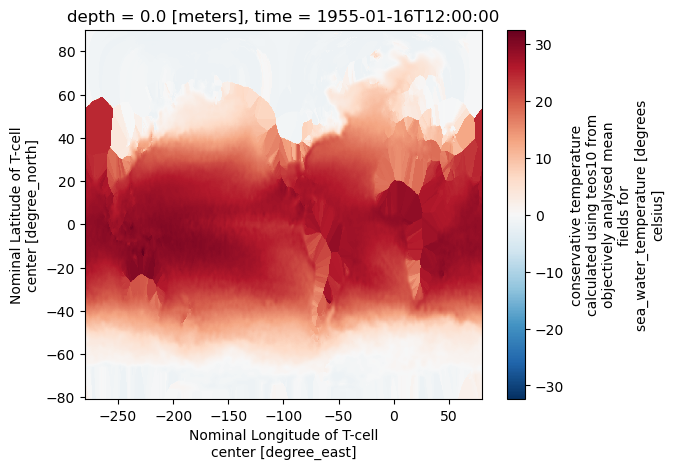

In [17]:
SST_obs.plot()

In [18]:
fields = ['tos']
field = fields[0]
data = dict()
for k in fields:
    d = { n: ds.search(variable=k, frequency='1day', variable_cell_methods='.*time: mean.*') for n, ds in datastores.items() }
    # d = { n: ds.search(variable=k) for n, ds in datastores.items() }
    # d = { n: ds.search(variable=k, frequency='1mon', variable_cell_methods='.*time: mean.*') for n, ds in datastores.items() }
    d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
    data[k] = d
data

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

{'tos': {'om3_MC_25km_jra_ryf_631+634+235': <xarray.Dataset> Size: 48GB
  Dimensions:  (time: 7300, yh: 1142, xh: 1440)
  Coordinates:
    * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
    * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
    * time     (time) object 58kB 1900-01-01 12:00:00 ... 1919-12-31 12:00:00
  Data variables:
      tos      (time, yh, xh) float32 48GB dask.array<chunksize=(1, 144, 240), meta=np.ndarray>
  Attributes: (12/15)
      title:                                    ACCESS-OM3
      associated_files:                         areacello: access-om3.mom6.stat...
      grid_type:                                regular
      grid_tile:                                N/A
      intake_esm_vars:                          ['tos']
      intake_esm_attrs:file_id:                 access_om3_mom6_2d_tos_1day_mea...
      ...                                       ...
      intake_esm_attrs:variable_standard_name

In [61]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1900, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(1908, 1, 1, 0, 0, 0, 0))

In [75]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1904, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(2549, 1, 1, 0, 0, 0, 0))

In [19]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1904, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(1908, 1, 1, 0, 0, 0, 0))

In [55]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1914, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(1918, 1, 1, 0, 0, 0, 0))

In [80]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(1925, 1, 1, 0, 0, 0, 0))

In [81]:
data

{'tos': {'om3_MC_25km_jra_ryf_631+634+235': <xarray.Dataset> Size: 48GB
  Dimensions:  (time: 7300, yh: 1142, xh: 1440)
  Coordinates:
    * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
    * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
    * time     (time) object 58kB 1900-01-01 12:00:00 ... 1919-12-31 12:00:00
  Data variables:
      tos      (time, yh, xh) float32 48GB dask.array<chunksize=(1, 144, 240), meta=np.ndarray>
  Attributes: (12/15)
      title:                                    ACCESS-OM3
      associated_files:                         areacello: access-om3.mom6.stat...
      grid_type:                                regular
      grid_tile:                                N/A
      intake_esm_vars:                          ['tos']
      intake_esm_attrs:file_id:                 access_om3_mom6_2d_tos_1day_mea...
      ...                                       ...
      intake_esm_attrs:variable_standard_name

In [82]:
data['tos']['om3_MC_25km_jra_ryf_631+634+235'].time

<xarray.DataArray 'time' (time: 7300)> Size: 58kB
array([cftime.DatetimeNoLeap(1900, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1919, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1919, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1919, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 58kB 1900-01-01 12:00:00 ... 1919-12-31 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

In [83]:
SST_mean = {
    n: ds[field].sel(time=trange).groupby('time.month').mean('time').sel(month=1)
    for n, ds in data[field].items()
}

AttributeError: 'IndexVariable' object has no attribute 'month'

In [23]:
key0 = list(SST_mean.keys())[0]

In [24]:
SST_obs = SST_obs.cf.assign_coords({ 'yh': SST_mean[key0]['yh'], 'xh': SST_mean[key0]['xh'] })
SST_obs

<xarray.DataArray 'temp' (yh: 1142, xh: 1440)> Size: 13MB
[1644480 values with dtype=float64]
Coordinates:
    depth    float64 8B 0.0
    time     datetime64[ns] 8B 1955-01-16T12:00:00
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
    month    int64 8B 1
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
Attributes:
    units:         degrees celsius
    long_name:     conservative temperature calculated using teos10 from obje...
    cell_methods:  area: mean depth: mean time: mean within years time: mean ...

/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_om3_MC_25km_jra_ryf_631+634+235.png


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.46 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_om3_MC_25km_jra_ryf_631+634+235.png
/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_test_current_config_0.0_w_rho_coord_with_GM_RR.png


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_test_current_config_0.0_w_rho_coord_with_GM_RR.png


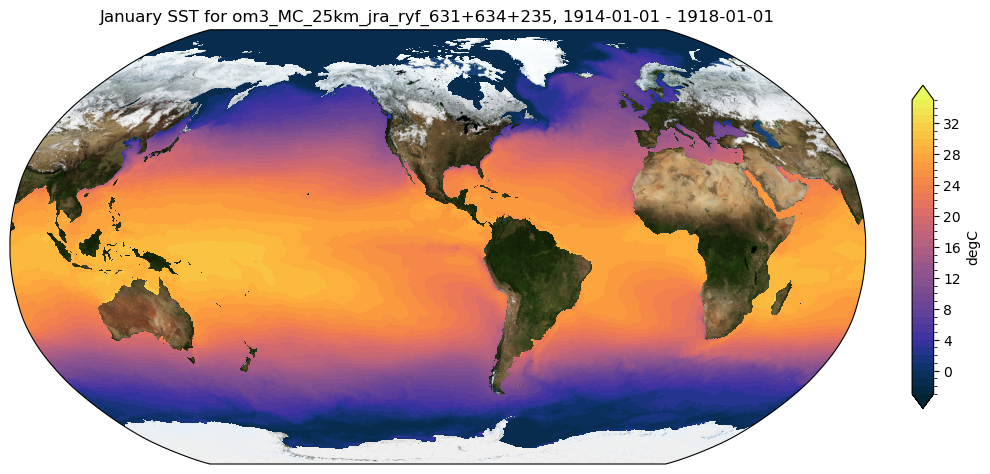

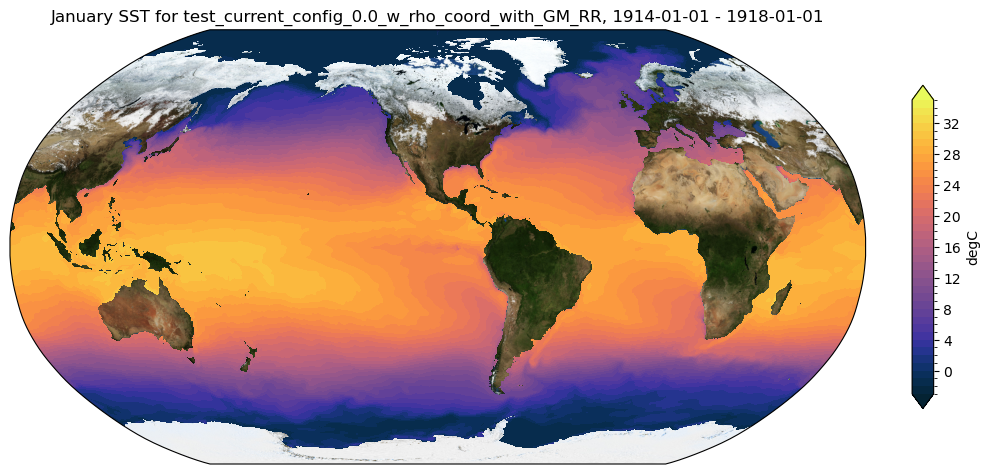

In [25]:
for n, ds in SST_mean.items():
    fname = thisdir+'SST_'+n+'.png'
    print(fname)
    if False: #os.path.isfile(fname):
        print(f'   ---- skipping existing file {fname}')
    else:
        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
        dat = ds.cf.assign_coords( { "longitude": static['geolon'],
                                     "latitude": static['geolat'] }).load()
        dat.plot.contourf(
            ax=ax,
            levels=39,
            vmin=-3,
            vmax=35,
            extend="both",
            cmap=cm.cm.thermal,#'thermal',
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"label": dat.attrs['units'], "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        )
        
        # Add blue marble land:
        ax.imshow(
            blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
        )
        
        plt.title(f"January SST for {n}, {trange.start.strftime('%Y-%m-%d')} - {trange.stop.strftime('%Y-%m-%d')}");
        
        plt.savefig(fname, dpi=150)
        print(f'   saved {fname}')


/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_bias_om3_MC_25km_jra_ryf_631+634+235.png


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 27.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_bias_om3_MC_25km_jra_ryf_631+634+235.png
/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_bias_test_current_config_0.0_w_rho_coord_with_GM_RR.png


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 26.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_bias_test_current_config_0.0_w_rho_coord_with_GM_RR.png


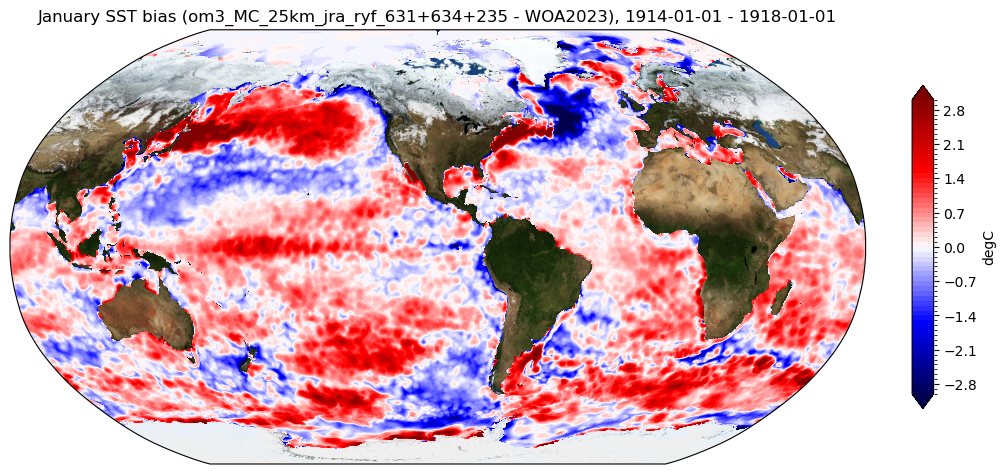

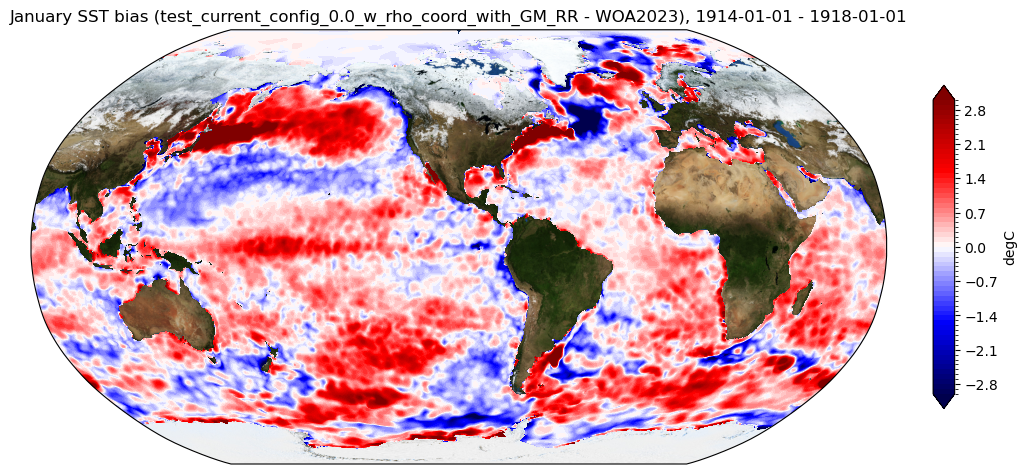

In [26]:
for n, ds in SST_mean.items():
    fname = thisdir+'SST_bias_'+n+'.png'
    print(fname)
    if False: #os.path.isfile(fname):
        print(f'   ---- skipping existing file {fname}')
    else:
        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
        dat = (ds - SST_obs # BUG: should convert to the same sort of temperature (eg conservative temperature)
              ).cf.assign_coords( { "longitude": static['geolon'],
                                     "latitude": static['geolat'] }).load()
        dat.plot.contourf(
            ax=ax,
            levels=61,
            vmin=-3,
            vmax=3,
            extend="both",
            cmap='seismic',
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"label": dat.attrs['units'], "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        )
        
        # Add blue marble land:
        ax.imshow(
            blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
        )
        
        plt.title(f"January SST bias ({n} - WOA2023), {trange.start.strftime('%Y-%m-%d')} - {trange.stop.strftime('%Y-%m-%d')}");
        
        plt.savefig(fname, dpi=150)
        print(f'   saved {fname}')
        # break


## ACCESS-OM2-025

In [78]:
# ACCESS-OM2-025 experiment
# use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258
om2expt = '025deg_jra55_ryf9091_gadi'
om2cat = intake.cat.access_nri[om2expt]
om2field = 'temp' # NB: surface_temp not available for this expt, and also has monthly data only for 1900-1903, and 2300-, with annual data in the gap

In [66]:
om2d = {om2expt: om2cat.search(variable=om2field, frequency='1mon').to_dask()}
om2data = {om2field: om2d}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into 

In [76]:
om2data

{'temp': {'025deg_jra55_ryf9091_gadi': <xarray.Dataset> Size: 948GB
  Dimensions:   (time: 3048, st_ocean: 50, yt_ocean: 1080, xt_ocean: 1440)
  Coordinates:
    * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
    * time      (time) object 24kB 1900-01-16 12:00:00 ... 2549-12-16 12:00:00
  Data variables:
      temp      (time, st_ocean, yt_ocean, xt_ocean) float32 948GB dask.array<chunksize=(1, 10, 216, 288), meta=np.ndarray>
  Attributes: (12/16)
      filename:                                 ocean.nc
      title:                                    ACCESS-OM2-025
      grid_type:                                mosaic
      grid_tile:                                1
      intake_esm_vars:                          ['temp']
      intake_esm_attrs:filename:                ocean.nc
      ...    

In [77]:
om2data[om2field]['025deg_jra55_ryf9091_gadi'].isel(st_ocean=0).time.sel(time=trange)#.groupby('time.month')

<xarray.DataArray 'time' (time: 2988)> Size: 24kB
array([cftime.DatetimeNoLeap(2300, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2300, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2300, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2548, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2548, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2548, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    st_ocean  float64 8B 1.152
  * time      (time) object 24kB 2300-01-16 12:00:00 ... 2548-12-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

In [46]:
om2SST_mean = {
    n: ds[om2field].isel(st_ocean=0).sel(time=trange).groupby('time.month').mean('time').sel(month=1)
    for n, ds in om2data[om2field].items()
}

AttributeError: 'IndexVariable' object has no attribute 'month'

In [ ]:
[varname].isel(st_ocean=0)

In [40]:
d2[om2expt]

<xarray.DataArray 'temp' (time: 3048, yt_ocean: 1080, xt_ocean: 1440)> Size: 19GB
dask.array<getitem, shape=(3048, 1080, 1440), dtype=float32, chunksize=(1, 216, 288), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    st_ocean  float64 8B 1.152
  * time      (time) object 24kB 1900-01-16 12:00:00 ... 2549-12-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

In [24]:
om2cat

,unique
filename,7780
file_id,5
path,8951
filename_timestamp,7776
frequency,3
start_date,7778
end_date,7777
variable,176
variable_long_name,180
variable_standard_name,18


In [25]:
d2 = {om2expt: om2cat.search(variable='temp').to_dask().rename({'temp_surface_ave': 'tos'})}

ValueError: Expected exactly one dataset. Received 0 datasets. Please refine your search or use `.to_dataset_dict()`.

In [32]:
om2static = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

In [33]:
om2static

<xarray.Dataset> Size: 93MB
Dimensions:     (xt_ocean: 1440, yt_ocean: 1080, time: 1, xu_ocean: 1440,
                 yu_ocean: 1080)
Coordinates:
  * xt_ocean    (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean    (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.84 89.95
  * time        (time) object 8B 0002-01-01 00:00:00
  * xu_ocean    (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean    (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
    geolon_t    (yt_ocean, xt_ocean) float32 6MB ...
    geolat_t    (yt_ocean, xt_ocean) float32 6MB ...
    geolon_c    (yu_ocean, xu_ocean) float32 6MB ...
    geolat_c    (yu_ocean, xu_ocean) float32 6MB ...
Data variables:
    ht          (yt_ocean, xt_ocean) float32 6MB ...
    hu          (yu_ocean, xu_ocean) float32 6MB ...
    dxt         (yt_ocean, xt_ocean) float32 6MB ...
    dyt         (yt_ocean, xt_ocean) float32 6MB ...
    dxu         (yu_ocean, xu_ocean) float32 6MB ...
    dyu         (yu_ocean, xu_ocean) float32 6MB ...
    area_t      (yt_ocean, xt_ocean) float32 6MB ...
    area_u      (yu_ocean, xu_ocean) float32 6MB ...
    kmt         (yt_ocean, xt_ocean) float32 6MB ...
    kmu         (yu_ocean, xu_ocean) float32 6MB ...
    drag_coeff  (time, yu_ocean, xu_ocean) float32 6MB ...
Attributes:
    filename:   ocean_grid.nc
    title:      MOM5
    grid_type:  mosaic
    grid_tile:  1

In [28]:
om2obsds = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/jobfs/146066672.gadi-pbs/ipykernel_3048791/1006190390.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  om2obsds = xr.open_dataset('/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc')


In [29]:
om2obsds

<xarray.Dataset> Size: 1GB
Dimensions:   (GRID_X_T: 1440, GRID_Y_T: 1080, ZT: 50, time: 1)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * GRID_Y_T  (GRID_Y_T) float64 9kB -81.08 -80.97 -80.87 ... 89.73 89.84 89.94
  * ZT        (ZT) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * time      (time) object 8B 0001-01-02 00:00:00
Data variables:
    temp      (time, ZT, GRID_Y_T, GRID_X_T) float64 622MB ...
    salt      (time, ZT, GRID_Y_T, GRID_X_T) float64 622MB ...
Attributes:
    history:   | Created on Thu Oct 15 21:10:51 AEDT 2020 using https://githu...

In [30]:
om2SST_obs = om2obsds['temp'].isel(ZT=0).isel(time=0).rename({'GRID_Y_T': 'yh', 'GRID_X_T': 'xh'})
om2SST_obs

<xarray.DataArray 'temp' (yh: 1080, xh: 1440)> Size: 12MB
[1555200 values with dtype=float64]
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -81.08 -80.97 -80.87 -80.76 ... 89.73 89.84 89.94
    ZT       float64 8B 1.152
    time     object 8B 0001-01-02 00:00:00
Attributes:
    long_name:  conservative temperature calculated using teos10 from objecti...
    units:      degrees celsius

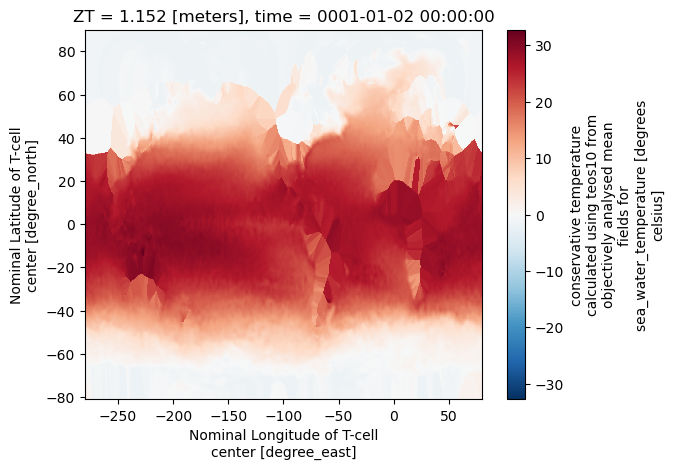

In [31]:
om2SST_obs.plot()

/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_om3_MC_25km_jra_ryf_631+634+235.png


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.46 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_om3_MC_25km_jra_ryf_631+634+235.png
/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_test_current_config_0.0_w_rho_coord_with_GM_RR.png


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 16.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_test_current_config_0.0_w_rho_coord_with_GM_RR.png


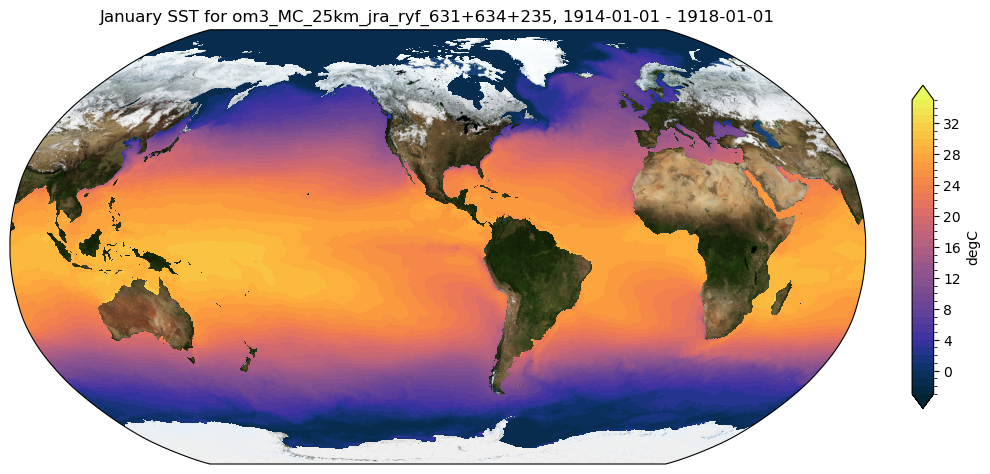

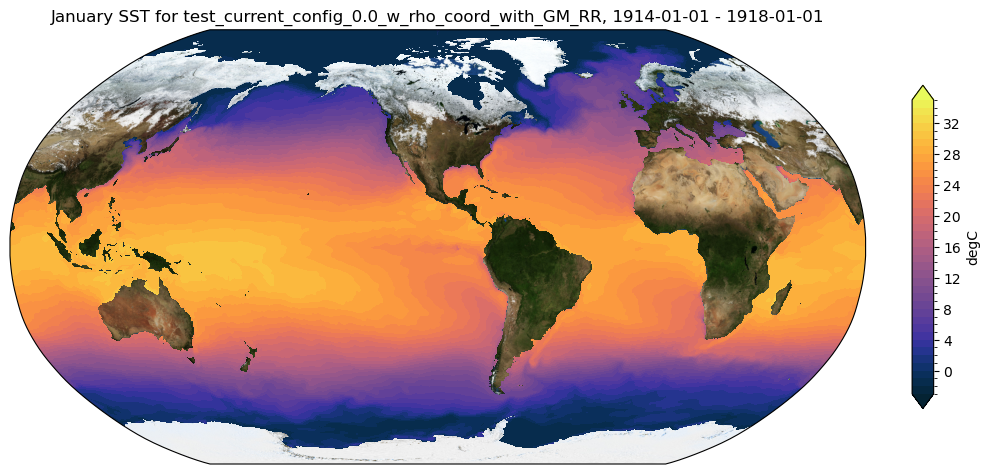

In [25]:
for n, ds in SST_mean.items():
    fname = thisdir+'SST_'+n+'.png'
    print(fname)
    if False: #os.path.isfile(fname):
        print(f'   ---- skipping existing file {fname}')
    else:
        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
        dat = ds.cf.assign_coords( { "longitude": static['geolon'],
                                     "latitude": static['geolat'] }).load()
        dat.plot.contourf(
            ax=ax,
            levels=39,
            vmin=-3,
            vmax=35,
            extend="both",
            cmap=cm.cm.thermal,#'thermal',
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"label": dat.attrs['units'], "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        )
        
        # Add blue marble land:
        ax.imshow(
            blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
        )
        
        plt.title(f"January SST for {n}, {trange.start.strftime('%Y-%m-%d')} - {trange.stop.strftime('%Y-%m-%d')}");
        
        plt.savefig(fname, dpi=150)
        print(f'   saved {fname}')
